1.  piisavalt andmeid et keskväärtuste viga jookseks 0.
    - et keskv ennustus töötab
2.  kas variacne sisukas. kas konst func. et keskv oleks lihtne. müra lineaarne.
    et kas mudel saab pihta veale/mürale, paljude anmdetegea.
    \sihilikult hpiame fikseeritud arhitektuuri.
    tulevikus tutleb võtta kui väikest katsetust sest arhitektuure peaks ka uurima

    - et kas 2 koondub 1te.
      eeldusel et andmed ülutihedalt

3.  kui sama olukord aga vähem andmeid. ülesobitamise määra võrdlus kui hea 2 on. - **kui 1000-10 punkti, fookus 10-100 punkti juures** - ülespbitamist saab treening- vs testviga - testviga saab mõõta samadel X-del, sest müra on mingi valemiga paigas. Või lihtsalt ama jaotus. - Tuleks eksp mitu korda jooksutada. keskmistada. - tuleb väheste andmepunktidega X endid ka muuta asukohta veidi lisaks mürale. - vähem andmeid =? suurem ülesobitus (testviga>>treening). - ülesobitus sümptom 2: 2 hakkab väiksemaks kui 3. - kui palju 2<3 versus treening&test **MSE** erinevus. **uurimisküsimus** - kas 2miinus3 on seotud treening-test viga -> 3 ongi testviga ehk kas 2 on treeningviga.
    **vahe muutumine andmete suurusega seoses. kuidas 2 on treeningveaga sõltuvuses. .võib ka vaadata 2-3 märki, kui on väikesem siis on liiga enesekindel & vice versa**
    **vahet saaks vaadata eri kohtades. kõik eelnev nii globaalne kui ka lookaalne**
    **kas serva efekt eksisteerib** - ei ole vaja ette geneda kõike

               2 on treeningviga:
                  -

    ^ sealt valida mõned suurused välja 4) jaoks, tegelikult 1/5 jaoks . uuritav arv on /5, see on B, ja siis 1-5 valemitest leian A.

4.  X telje genereerimine seada mitte ühtlaseks.
    praegu saab globaalsest andmemahust seonduvad asjad. sest glob u= lok
    kui teha eraldi siis enam ei ole sama
    sujuv vs järsk tihedusemuut - kui järsk siis saab akna piiri uurida

5 piirkonda. 4 piirkonda üks ja 1 on teine. -- saab vaadata milline faktor loeb rohkeim
A = 1 tihedus,
B = 4 ülejäänude tihedused

Tsenaarium:

1. A = 4\*B
2. A = 2\*B (poole tihedam)
3. A = 1\*B (jooksutada vähem, ei ole vaja 5x)
4. A = B/2
5. A = B/4
   ^ VÕTTA random.uniform() mitte linspace()
   testandmed geneda linspace abil (need hpida konstantsena, eelgene jne)

KAS SUURENDADA LOKAALSET ARVU VÕI GLOAALSET ARVU (20-20-20-20-20 -> 16-16-16-16-32 VÕI 20-20-20-20-40) (40 variant parem vb)
** lokaalsete muutuste uurimiseks tasub muuta X_test asukohta võrreldes train**

batch size olgu min(andmed/5, 16)
esimene kahe aste mis ületab len(andmed)/5


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%cd ..


c:\Users\troosma\Documents\Ylikool\6. semester\Bakatöö\bakatoo


In [47]:
import sys
import os

import numpy as np
import random
import tensorflow as tf

from tensorflow import keras
from keras import layers

from matplotlib import pyplot as plt
import seaborn as sns

from scripts.CustomCallbacks import CustomLogger
import scripts.utils as utils
import scripts.Slopes as Slopes

from tqdm import tqdm
import json
utils.reset_seeds(0)


## 20-20 relu, const func, noise = 0.3 + 0.3X


In [3]:
def train_model(
    trainX: np.ndarray,
    nn_size: tuple[int, int] = (20, 20),
    optimizer: keras.optimizers = keras.optimizers.Adam(
        learning_rate=0.003, amsgrad=True, epsilon=1e-3),
    epochs: int = 1000,
    batch_size: int = None,
    fn=lambda x: 0*x,
    noise_fn=lambda x: 0.3 *
        np.random.randn(len(x)) + 0.3 * x * np.random.randn(len(x)),
    reverse_fn: bool = False,
    reverse_noise: bool = False,
    seed: int = None
) -> tuple[keras.Model, keras.callbacks.History, tuple[np.ndarray, np.ndarray]]:
    """Mudeli treenimine, võib kasutada erinevaid funktsioone ja müra, tagastab mudeli, ajaloo ja treeningandmed

    :param trainX: treeningX andmed
    :param nn_size: võrgu kihtide suurused, hetkel ainult 2 kihti lubatud, defaults to (20, 20)
    :param optimizer: optimiseerija, hetkel valitud hea väiksematele andmehulkadele, defaults to keras.optimizers.Adam( learning_rate=0.003, amsgrad=True, epsilon=1e-3)
    :param epochs: epochide kogus, defaults to 1000
    :param batch_size: batch size, kasutab valemit min(16, kahe aste mis > len(X)/5), defaults to 16
    :param fn: funktsioon mida õppida, defaults to lambdax:0*x
    :param noise_fn: mürafn, defaults to lambdax:0.3*np.random.randn(len(x))+0.3*x*np.random.randn(len(x))
    :param reverse_fn: kas pöörata fn tagurpidi, defaults to False
    :param reverse_noise: kas pöörata müra tagurpidi, defaults to False
    :param seed: seed, defaults to 42
    :return: treenitud mudel, ajalugu, treeningandmed
    """

    utils.reset_seeds(seed)

    model = keras.Sequential([
        layers.Input(shape=(1,)),
        layers.Dense(units=nn_size[0], activation='relu', name="layer_1"),
        layers.Dense(units=nn_size[1], activation='relu', name="layer_2"),
        layers.Dense(units=2, activation='linear', name="layer_3")
    ])

    X = trainX

    # kõik võimalikud kombod reverse_fn ja reverse_noise. Default on tavalist pidi
    if reverse_fn and reverse_noise:
        y = fn(X[::-1]) + noise_fn(X[::-1])
    elif reverse_fn:
        y = fn(X[::-1]) + noise_fn(X)
    elif reverse_noise:
        y = fn(X) + noise_fn(X[::-1])
    else:
        y = fn(X) + noise_fn(X)

    X_train, y_train = X, y

    model.compile(
        optimizer=optimizer,
        loss=utils.neg_log_likelihood,
    )

    if batch_size is None:
        batch_size = min(16, max(2, 2**int(np.log2(len(trainX)/5+0.001)+1)))

    # TODO: validation_batch_size ja validation_freq saab kasutada et vaadata kuidas viga treeningu jooksul muutub
    h = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0,
                  callbacks=[CustomLogger(100)], shuffle=True, )
    return model, h, (X_train, y_train)


def fn(X): return 0*X


def noise_fn(X): return 0.3 * np.random.randn(len(X)) + \
    0.3 * X * np.random.randn(len(X))


In [37]:
train_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180,
               190, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900, 1000, 2000, 5000, 10**4, 10**5, 10**6]
X_grid_test = np.linspace(0, 10, 10**7)
y_grid_test = fn(X_grid_test) + noise_fn(X_grid_test)
test_goal = 10**7

n_runs = 5
seeds = np.arange(n_runs)
epochs = 10

In [5]:
goal = 10
arr = np.arange(0, 3, 1)
np.repeat(arr, goal/len(arr))

array([0, 0, 0, 1, 1, 1, 2, 2, 2])

In [115]:
def save_everything(directory, train_size, seed, y_pred, rmses, mses, bp):
    np.save(f"{directory}/dumps/{train_size}/{seed}/y_pred", y_pred)
    np.save(f"{directory}/dumps/{train_size}/{seed}/rmses", rmses)
    np.save(f"{directory}/dumps/{train_size}/{seed}/bpoints", bp)
    with open(f"test2/19_hpc_script/dumps/{train_size}/{seed}/mses.json", "w+") as f:
        json.dump(
        dict(zip(["mse_treeningul","mse_grid_testil","mse_treening_andmete_teine_myra"], map(lambda x: float(x.numpy()), mses))),
        f)

In [39]:
def samad_punktid_kui_treeningul_teine_myra(X_train, model, fn, noise_fn, test_goal):
    X_test = np.repeat(X_train, test_goal/len(X_train))
    y_test = fn(X_test) + noise_fn(X_test)
    y_pred = model.predict(X_test, batch_size=65536)
    return keras.losses.mean_squared_error(y_test, y_pred[:,0])

Epoch:   0 | Loss: 1.92664e+00
153/153 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: test2/19_hpc_script/models/10_0\assets
model contains 28 breaks
1/1 [==============================] - 0s 22ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'test2/19_hpc_script/plots/variance/10_0.png'

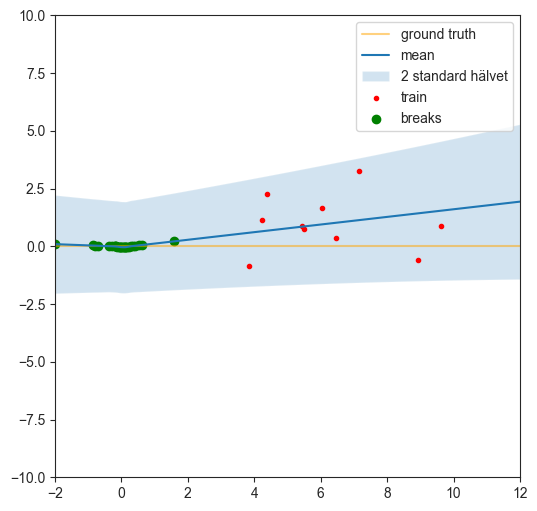

In [129]:
for train_size in train_sizes:    # kõik suurused
    for seed in seeds:  # kõik seedid
        utils.reset_seeds(seed)
        X_train = np.random.uniform(0, 10, train_size)
        model, h, (X_train, y_train) = train_model(
            X_train, nn_size=(20, 20), epochs=epochs,
            fn=fn, noise_fn=noise_fn, seed=seed
        )
        y_pred_train = model.predict(X_train, batch_size=65536, verbose=0)
        y_pred_grid = model.predict(X_grid_test, batch_size=65536, verbose=0)

        mse_treeningul = keras.losses.mean_squared_error(y_train, y_pred_train[:, 0])
        mse_grid_testil = keras.losses.mean_squared_error(y_grid_test, y_pred_grid[:, 0])
        mse_treening_andmete_teine_myra = samad_punktid_kui_treeningul_teine_myra(X_train, model, fn, noise_fn, test_goal)

        model.save(
            f"test2/19_hpc_script/models/{train_size}_{seed}", overwrite=True)
        # m = tf.keras.models.load_model("test2/19_hpc_script/models/10_0", custom_objects={'neg_log_likelihood': utils.neg_log_likelihood})
        

        variance_fig = utils.joonista_variance(model, X_test=np.linspace(-2, 12, 1000), X_train=X_train, y_train=y_train,
                        xlim=(-2, 12), ylim=(-10, 10), ground_truth=fn, bpoint_fn=Slopes.new_breakpoint_finder, return_fig=True)
        variance_fig.savefig(f"test2/19_hpc_script/plots/variance/{train_size}_{seed}.png")

        rmses, rmse_fig = utils.joonista_rmses5x(model=model, start=0, end=10, steps=1000, akna_laius=0.1,
                                            fn=lambda x: 0*x, analyytiline_myra=lambda x: 0.09*x**2+0.09, show_plt=False)
        rmse_fig.savefig(f"test2/19_hpc_script/plots/rmses/{train_size}_{seed}.png")

        bpoints = Slopes.new_breakpoint_finder(model, np.linspace(-2, 12, 10**6))
        bpoints = [bp[0] for bp in bpoints]

        save_everything(train_size,seed, y_pred=y_pred_grid, rmses=rmses, mses=[mse_treeningul, mse_grid_testil, mse_treening_andmete_teine_myra], bp=bpoints)

        break
    break

In [ ]:
korduv_test_viga.append([])
korduv_treening_viga.append([])
for i in range(5):  # tõmbame kõiki eksperimente 5x
    x_train = np.linspace(0, 10, dset_size)

    m, h, (x_train, y_train, x_truth, ground_truth) = train_model_nb(
         x_train, **param_dict[dset_size], seed=None, optimizer=opt)

     rmses, fig = utils.joonista_rmses5x(
          m, start=-2, end=12, steps=1000, fn=fn, akna_laius=0.1, return_fig=True)

      # treening viga
      korduv_treening_viga[-1].append(m.evaluate(x_train,
                                                  y_train, verbose=0))

       # test viga
       if len(x_train) < goal_test:
            uus_x = np.repeat(x_train, goal_test/len(x_train))
        else:
            uus_x = x_train
        y_test = fn(uus_x) + 0.3*np.random.randn(len(uus_x)) + \
            0.3*uus_x*np.random.randn(len(uus_x))
        viga = m.evaluate(uus_x, y_test, verbose=0)
        korduv_test_viga[-1].append(viga)
